In [1]:
!git clone https://github.com/nNithyaChandrasekar/Ovarian-Cancer-Classification.git

Cloning into 'Ovarian-Cancer-Classification'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
from skimage.feature import local_binary_pattern
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix

In [ ]:
def apply_gamma_correction_own_function(image, gamma=1.1):
    normalized_image = image / 255.0
    gamma_corrected = normalized_image ** gamma
    gamma_corrected_image = np.array(255 * gamma_corrected, dtype='uint8')
    return gamma_corrected_image

def preprocess_cell_image(image_path):
    image = cv2.imread(image_path)

    if image is None:
        return None  # Silently skip invalid images

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    edges = cv2.Canny(blurred_image, threshold1=30, threshold2=100)

    kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(edges, kernel, iterations=1)

    result_image = cv2.bitwise_or(image, image, mask=dilated_image)

    return result_image

input_folder = "/content/drive/MyDrive/OvarianCancercn"
output_folder = "/content/drive/MyDrive/OC"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for subfolder in os.listdir(input_folder):
    subfolder_path = os.path.join(input_folder, subfolder)
    output_subfolder_path = os.path.join(output_folder, subfolder)

    if not os.path.isdir(subfolder_path):
        continue

    if not os.path.exists(output_subfolder_path):
        os.makedirs(output_subfolder_path)

    image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for image_name in image_files:
        image_path = os.path.join(subfolder_path, image_name)
        processed_image = preprocess_cell_image(image_path)

        if processed_image is not None:
            output_path = os.path.join(output_subfolder_path, image_name)
            cv2.imwrite(output_path, processed_image)

print("Dataset Preprocessing Completed!")

Dataset Preprocessing Completed!


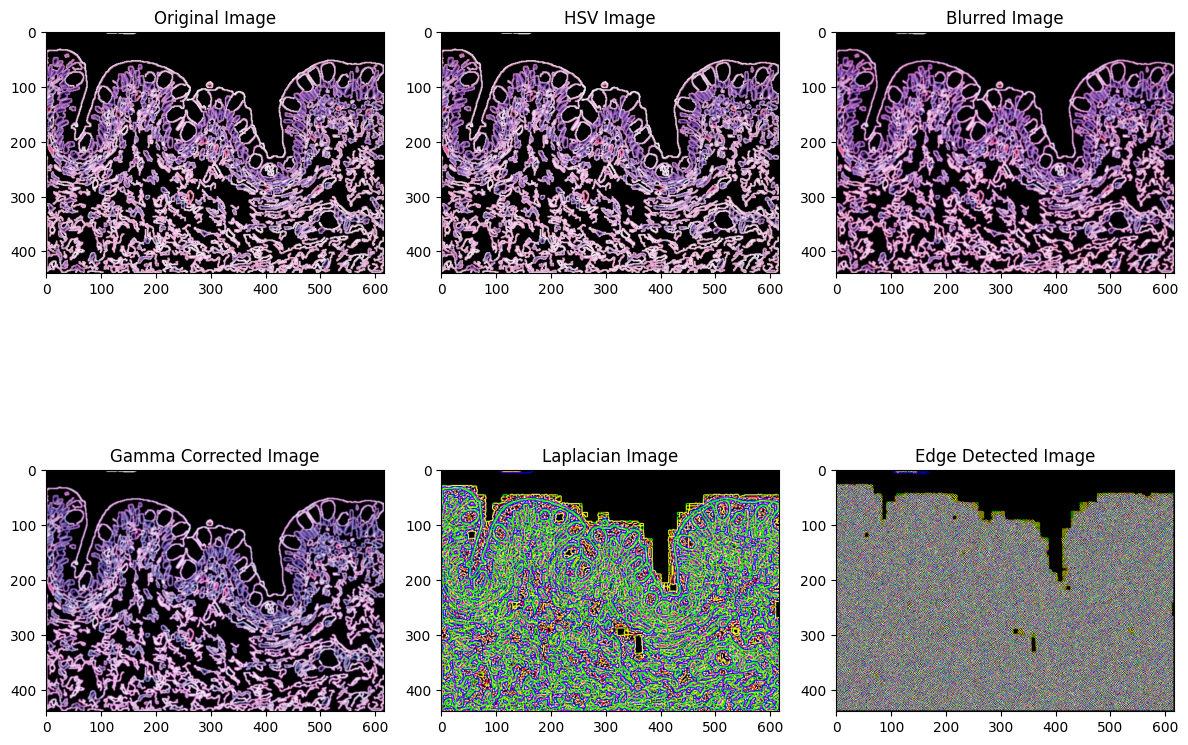

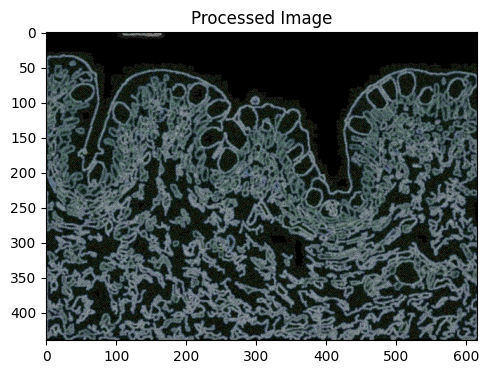

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[ 58,  63,  52],
        [108,  61, 110],
        [ 72,  57, 109],
        ...,
        [114,  67,  96],
        [118, 116,  79],
        [ 68, 111,  13]],

       [[ 18, 111,  12],
        [ 51, 109,  28],
        [ 63, 108,  60],
        ...,
        [ 77, 129,  58],
        [101, 115,  32],
        [ 45, 110,   0]],

       [[  0, 128,   0],
        [  8, 124,   0],
        [ 18, 120,   0],
        ...,
        [ 72, 102,  13],
        [ 51, 106,   0],
        [ 32,  92,   0]]], dtype=uint8)
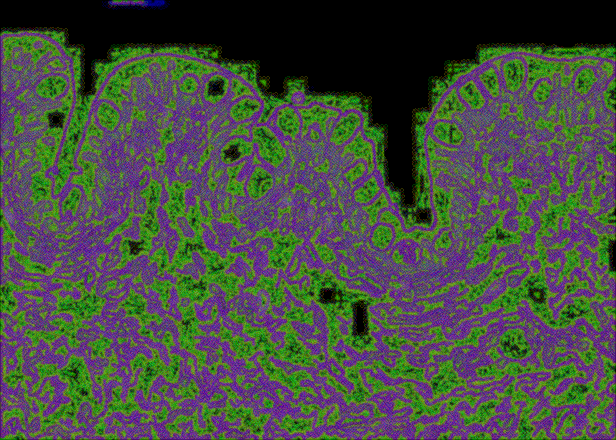

In [ ]:
def visualize_preprocessing_steps(image_path):
    global skipped_images_count
    image = cv2.imread(image_path)
    plt.figure(figsize=(12, 10))

    if image is None:
        skipped_images_count += 1
        print("Skipped an image")
        return None

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB))
    plt.title("HSV Image")

    blurred_image = cv2.GaussianBlur(hsv_image, (3, 3), 0)
    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_HSV2RGB))
    plt.title("Blurred Image")

    gamma_corrected_image = apply_gamma_correction_own_function(blurred_image)
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.cvtColor(gamma_corrected_image, cv2.COLOR_HSV2RGB))
    plt.title("Gamma Corrected Image")

    laplacian_image = cv2.Laplacian(gamma_corrected_image, cv2.CV_64F)
    plt.subplot(2, 3, 5)
    plt.imshow(laplacian_image, cmap='gray')
    plt.title("Laplacian Image")

    edges = cv2.Sobel(src=laplacian_image, ddepth=cv2.CV_64F, dx=3, dy=3, ksize=5)
    plt.subplot(2, 3, 6)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detected Image")

    plt.tight_layout()
    plt.show()

    processed_image = cv2.addWeighted(gamma_corrected_image, 0.5, edges.astype(np.uint8), 0.2, 0)
    plt.figure(figsize=(6, 4))
    plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_HSV2RGB))
    plt.title("Processed Image")
    plt.show()

    return processed_image

image_path_per = '/content/drive/MyDrive/OC/Mucinous/mucinua9.JPG'
visualize_preprocessing_steps(image_path_per)

In [ ]:
class OvarianCancerDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        self.paths_and_labels = []
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = [os.path.join(class_dir, file_name) for file_name in os.listdir(class_dir)]
            self.paths_and_labels.extend([(path, label) for path in image_paths])

    def __len__(self):
        return len(self.paths_and_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_and_labels[idx]
        image = cv2.imread(image_path)
        if image is None:
            return torch.zeros(3, 224, 224), label
        image = self.transform(image)
        return image, label


def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Define transforms separately
    train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.RandomCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_val_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create the full dataset without train/val split
    full_dataset = OvarianCancerDataset(root_dir=root_dir)

    # Split dataset into train, validation, and test sets
    total_size = len(full_dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

    # Assign different transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = test_val_transform
    test_dataset.dataset.transform = test_val_transform

    return train_dataset, val_dataset, test_dataset


In [ ]:
data_dir_ovarian_base = "/content/drive/MyDrive/OC"

train_dataset, val_dataset, test_dataset = create_datasets(root_dir=data_dir_ovarian_base)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## Processed Image Loader

In [ ]:
class OvarianCancerDataset(Dataset):
    def __init__(self, root_dir, train=True):
        self.root_dir = root_dir
        self.train = train
        self.classes = os.listdir(root_dir)
        self.paths_and_labels = []

        if self.train:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256)),
                transforms.RandomCrop((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet veri seti ortalaması ve std
            ])
        else:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            image_paths = [os.path.join(class_dir, file_name) for file_name in os.listdir(class_dir)]
            self.paths_and_labels.extend([(path, label) for path in image_paths])

    def __len__(self):
        return len(self.paths_and_labels)

    def __getitem__(self, idx):
        image_path, label = self.paths_and_labels[idx]
        image = preprocess_cell_image(image_path)
        if image is None:
            return torch.zeros(3, 224, 224), label
        image = self.transform(image)
        return image, label

def create_datasets(root_dir, train_ratio=0.7, val_ratio=0.15):
    from torch.utils.data import random_split

    # Load full dataset
    dataset = OvarianCancerDataset(root_dir=root_dir, train=True)

    # Compute sizes
    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size  # Ensure all data is used

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Assign proper dataset objects
    val_dataset.dataset = OvarianCancerDataset(root_dir=root_dir, train=False)
    test_dataset.dataset = OvarianCancerDataset(root_dir=root_dir, train=False)

    return train_dataset, val_dataset, test_dataset


In [ ]:
data_dir_ovarian_base = "/content/drive/MyDrive/OC"
train_dataset, val_dataset, test_dataset = create_datasets(root_dir=data_dir_ovarian_base)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


## CNN Model (Optional)

In [ ]:
class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        #self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)

        self.dropout_conv = nn.Dropout2d(p=0.3)

        self.pool = nn.MaxPool2d(2, 2)

        # FCL
        self.fc1 = nn.Linear(256 * 14 * 14, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)

        self.dropout_fc = nn.Dropout(p=0.4)

        self.output = nn.Linear(64, 5)

    def forward(self, x):
        x = self.dropout_conv(F.elu(self.conv1(x)))
        x = self.dropout_conv(F.elu(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv3(x)))
        x = self.dropout_conv(F.elu(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv5(x)))
        x = self.dropout_conv(F.elu(self.conv6(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv7(x)))
        x = self.dropout_conv(F.elu(self.conv8(x)))
        x = self.pool(x)

        x = x.view(-1, 256 * 14 * 14)

        x = self.dropout_fc(F.elu(self.fc1(x)))
        x = self.dropout_fc(F.elu(self.fc2(x)))
        x = self.dropout_fc(F.elu(self.fc3(x)))

        x = self.output(x)
        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
class DCNN(nn.Module):
    def __init__(self):
        super(DCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.dropout_conv = nn.Dropout2d(p=0.2)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 64)
        self.fc2 = nn.Linear(64, 5)
        self.dropout_fc = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout_conv(F.elu(self.conv1(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout_conv(F.elu(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 28 * 28)

        x = self.dropout_fc(F.elu(self.fc1(x)))
        x = self.dropout_fc(F.elu(self.fc2(x)))

        x = F.log_softmax(x, dim=1)

        return x

In [ ]:
model = DCNN()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Trainer for CNN with test evaluation
def train(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs, train_losses, val_losses, val_accuracies):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_accuracy:.2f}%')

    # Evaluate on test set after training
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'\nTest Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy


In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

test_loss, test_accuracy = train(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs=1, train_losses=train_losses, val_losses=val_losses, val_accuracies=val_accuracies)

Epoch 1/1: Train Loss: 1.718, Val Loss: 1.556, Val Accuracy: 25.20%

Test Loss: 1.541, Test Accuracy: 30.21%




## MobilenetV3: Model

In [ ]:
class FuzzyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(FuzzyConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x) * x

class FuzzyMaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2):
        super(FuzzyMaxPool2d, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size, stride)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()

    def forward(self, x):
        pooled_x = self.pool(x)
        pooled_x = self.bn(pooled_x)
        return self.relu(pooled_x) * pooled_x

class MobileNetV3Combined(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV3Combined, self).__init__()
        self.mobilenet_v3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

        for param in list(self.mobilenet_v3.features.parameters())[-10:]:
            param.requires_grad = True

        self.fuzzy_conv = FuzzyConv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.fuzzy_pool = FuzzyMaxPool2d(kernel_size=2, stride=2)

        in_features = self.mobilenet_v3.classifier[0].in_features
        self.mobilenet_v3.classifier = nn.Sequential(
            nn.Linear(in_features, 1280),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.fuzzy_conv(x)
        x = self.fuzzy_pool(x)
        return self.mobilenet_v3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MobileNetV3Combined(num_classes=5).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 76.4MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model Train

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs, train_losses, val_losses, val_accuracies, train_accuracies):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()  # Save the best model state
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.2f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.2f}, Val Accuracy: {val_accuracy:.2f}%")

    # Restore best model before testing
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("\nBest model restored before test evaluation.")

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy


In [ ]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

epochs = 60

test_loss, test_accuracy = train(model, criterion, optimizer, train_loader, val_loader, test_loader, epochs, train_losses, val_losses, val_accuracies, train_accuracies)

Epoch 1/60: Train Loss: 1.50, Train Accuracy: 34.67%, Val Loss: 1.64, Val Accuracy: 29.22%
Epoch 2/60: Train Loss: 1.39, Train Accuracy: 45.81%, Val Loss: 1.42, Val Accuracy: 40.48%
Epoch 3/60: Train Loss: 1.30, Train Accuracy: 50.86%, Val Loss: 1.49, Val Accuracy: 44.24%
Epoch 4/60: Train Loss: 1.20, Train Accuracy: 57.92%, Val Loss: 1.44, Val Accuracy: 52.01%
Epoch 5/60: Train Loss: 1.16, Train Accuracy: 60.05%, Val Loss: 1.31, Val Accuracy: 52.82%
Epoch 6/60: Train Loss: 1.08, Train Accuracy: 64.35%, Val Loss: 1.29, Val Accuracy: 55.76%
Epoch 7/60: Train Loss: 1.07, Train Accuracy: 65.33%, Val Loss: 1.24, Val Accuracy: 59.79%
Epoch 8/60: Train Loss: 0.99, Train Accuracy: 69.86%, Val Loss: 1.02, Val Accuracy: 71.05%
Epoch 9/60: Train Loss: 0.97, Train Accuracy: 70.84%, Val Loss: 1.06, Val Accuracy: 65.68%
Epoch 10/60: Train Loss: 0.92, Train Accuracy: 72.73%, Val Loss: 1.03, Val Accuracy: 67.29%
Epoch 11/60: Train Loss: 0.90, Train Accuracy: 74.80%, Val Loss: 0.92, Val Accuracy: 74.2

In [ ]:
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef

def evaluate_model(model, dataloader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute Cohen's Kappa and MCC
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

    return kappa, mcc

# Call the evaluation function after testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kappa, mcc = evaluate_model(model, test_loader, device)

Cohen's Kappa: 0.8360
Matthews Correlation Coefficient (MCC): 0.8392


##SAVE, RESULT, TEST

In [ ]:
def save_model(model, path='model.pth'):
    torch.save(model.state_dict(), path)
    print(f'Model saved to {path}')

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# predictor
def predict_random_images(model, dataset, num_images=15):
    model.eval()
    model.to(device)
    images, labels = zip(*[dataset[np.random.randint(len(dataset))] for _ in range(num_images)])
    images = torch.stack(images).to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

    return images.cpu(), predictions.cpu(), labels

def evaluate_predictions(predictions, labels):
    correct = (predictions == labels).sum().item()
    total = len(predictions)
    wrong = total - correct
    print(f'Total images: {total}, Correct predictions: {correct}, Wrong predictions: {wrong}')
    return correct, wrong

def get_model_predictions_for_roc(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_roc_curve(true_labels, model_preds, num_classes):
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):

        labels = (true_labels == i)
        preds = model_preds[:, i]

        fpr, tpr, _ = roc_curve(labels, preds)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='Class %d (area = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def get_confusion_matrix(true_labels, model_preds):
    pred_labels = np.argmax(model_preds, axis=1)
    cm = confusion_matrix(true_labels, pred_labels)
    return cm

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

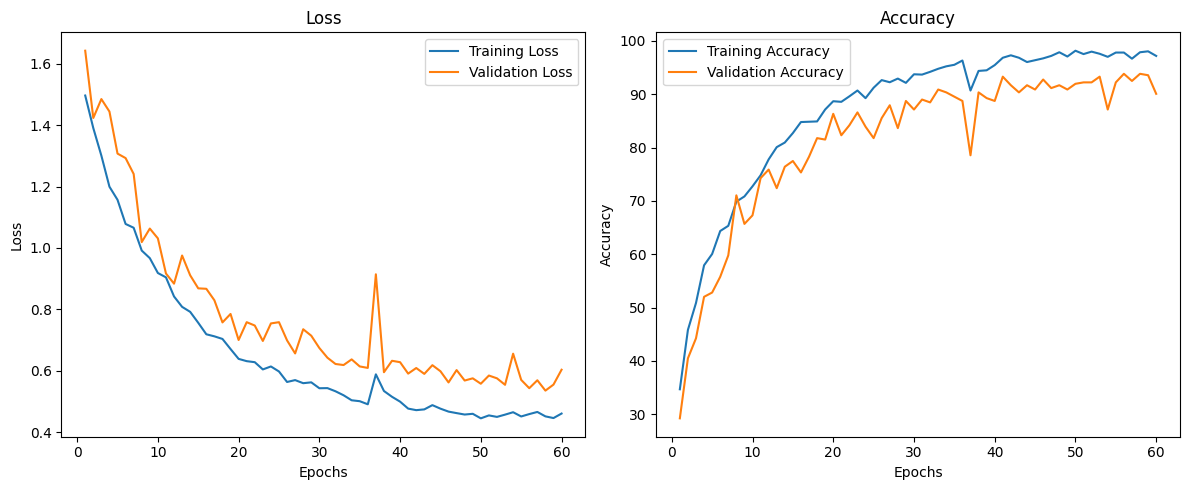

Total images: 15, Correct predictions: 14, Wrong predictions: 1


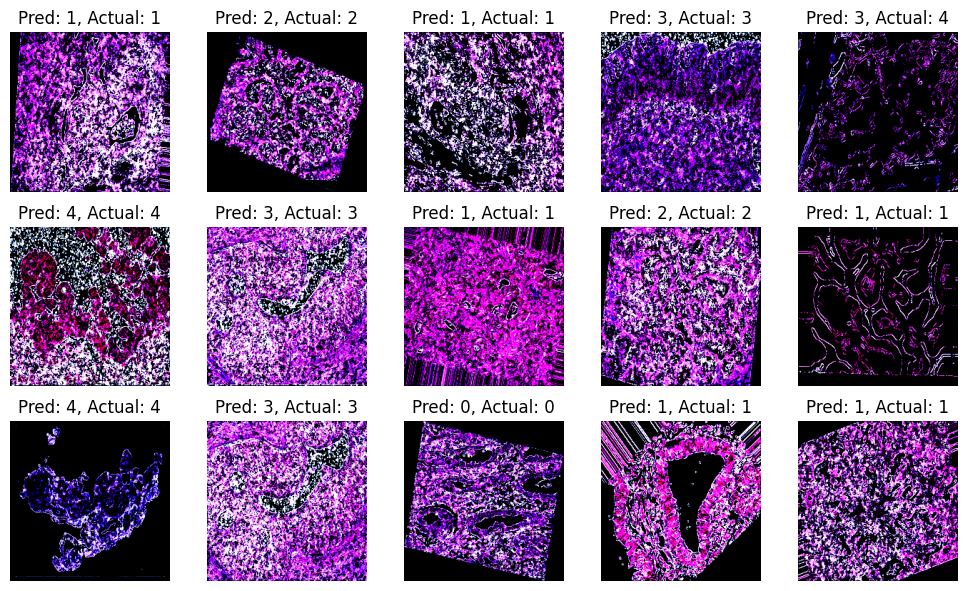

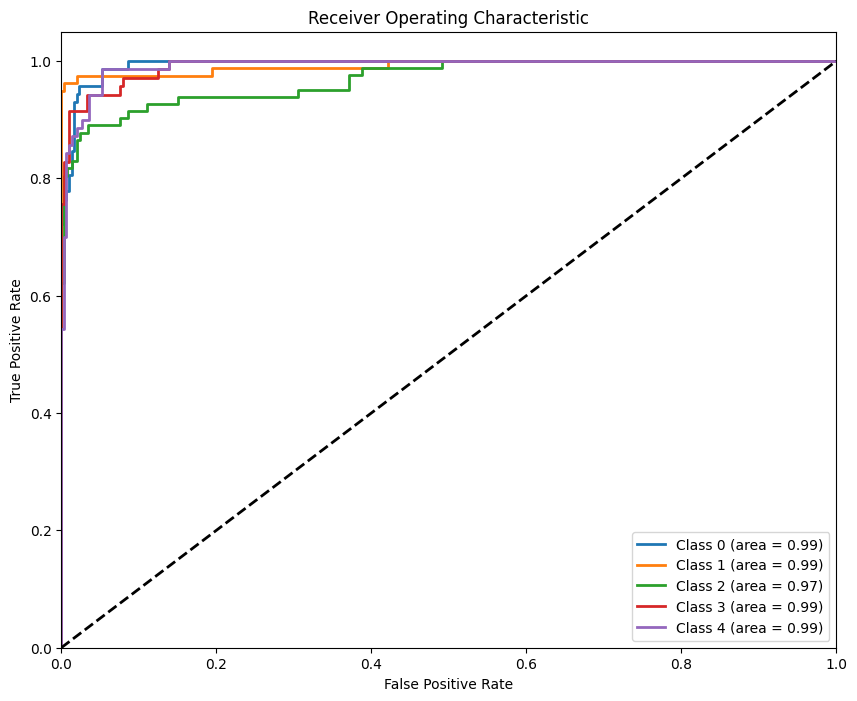

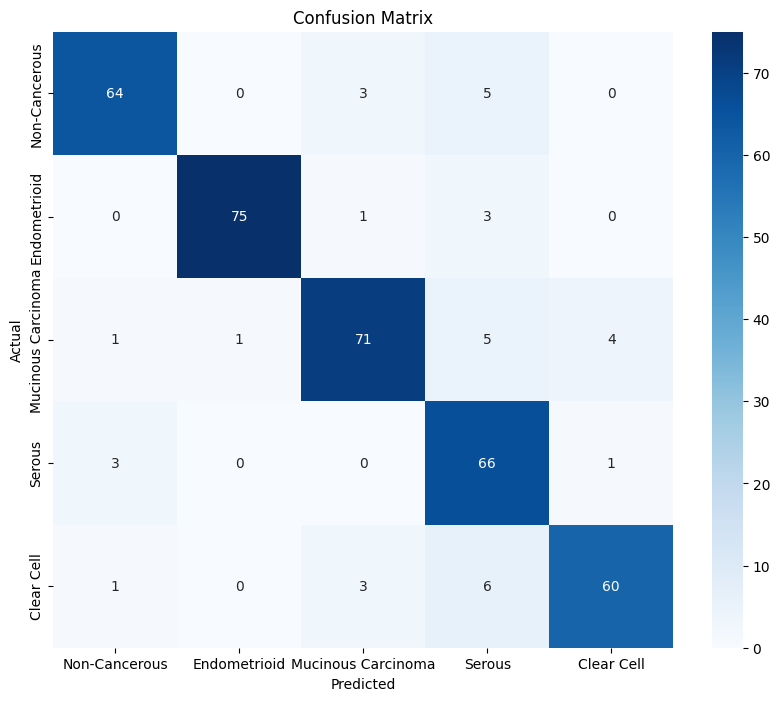

In [ ]:
# save_model(model, 'vgg19_finetuned.pth')

plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Random 15 image
images, predictions, labels = predict_random_images(model, val_dataset, num_images=15)
correct, wrong = evaluate_predictions(predictions, torch.tensor(labels))

num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))

for ax in axes.flatten()[len(images):]:
    ax.axis('off')

for i, ax in enumerate(axes.flatten()):
    if i >= len(images):
        break
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(f'Pred: {predictions[i]}, Actual: {labels[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

model_preds, true_labels = get_model_predictions_for_roc(model, val_loader, device)
plot_roc_curve(true_labels, model_preds, num_classes=5)

# Confusion matrix
cm = get_confusion_matrix(true_labels, model_preds)
class_names = ['Non-Cancerous', 'Endometrioid', 'Mucinous Carcinoma', 'Serous', 'Clear Cell']
plot_confusion_matrix(cm, class_names)


Input Tensor Shape: torch.Size([1, 3, 224, 224])
Raw Model Output: tensor([[-0.8182, -0.9864,  3.3719, -1.0097, -0.6654]])
Softmax Probabilities: tensor([0.0143, 0.0121, 0.9451, 0.0118, 0.0167])
Predicted Class Index: 2 -> Mucinous Carcinoma


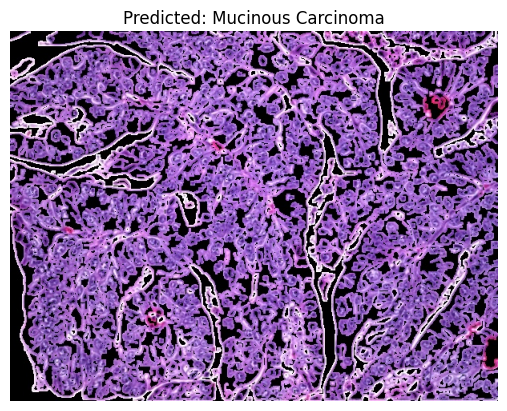

In [ ]:
def predict(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    print(f"Input Tensor Shape: {input_tensor.shape}")  # Debug: Check tensor shape

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        predicted_class = torch.argmax(probabilities).item()

    print(f"Raw Model Output: {output}")
    print(f"Softmax Probabilities: {probabilities}")
    print(f"Predicted Class Index: {predicted_class} -> {class_names[predicted_class]}")

    plt.imshow(image)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

    return class_names[predicted_class], probabilities[predicted_class].item()

# Example usage
image_path = "/content/drive/MyDrive/OC/Mucinous/71.JPG"
predicted_label, confidence = predict(image_path)
